In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Time-Series-Anomaly-Detection/spx.csv', parse_dates=['date'], index_col='date')

In [ ]:
df.shape

(8192, 1)

In [ ]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


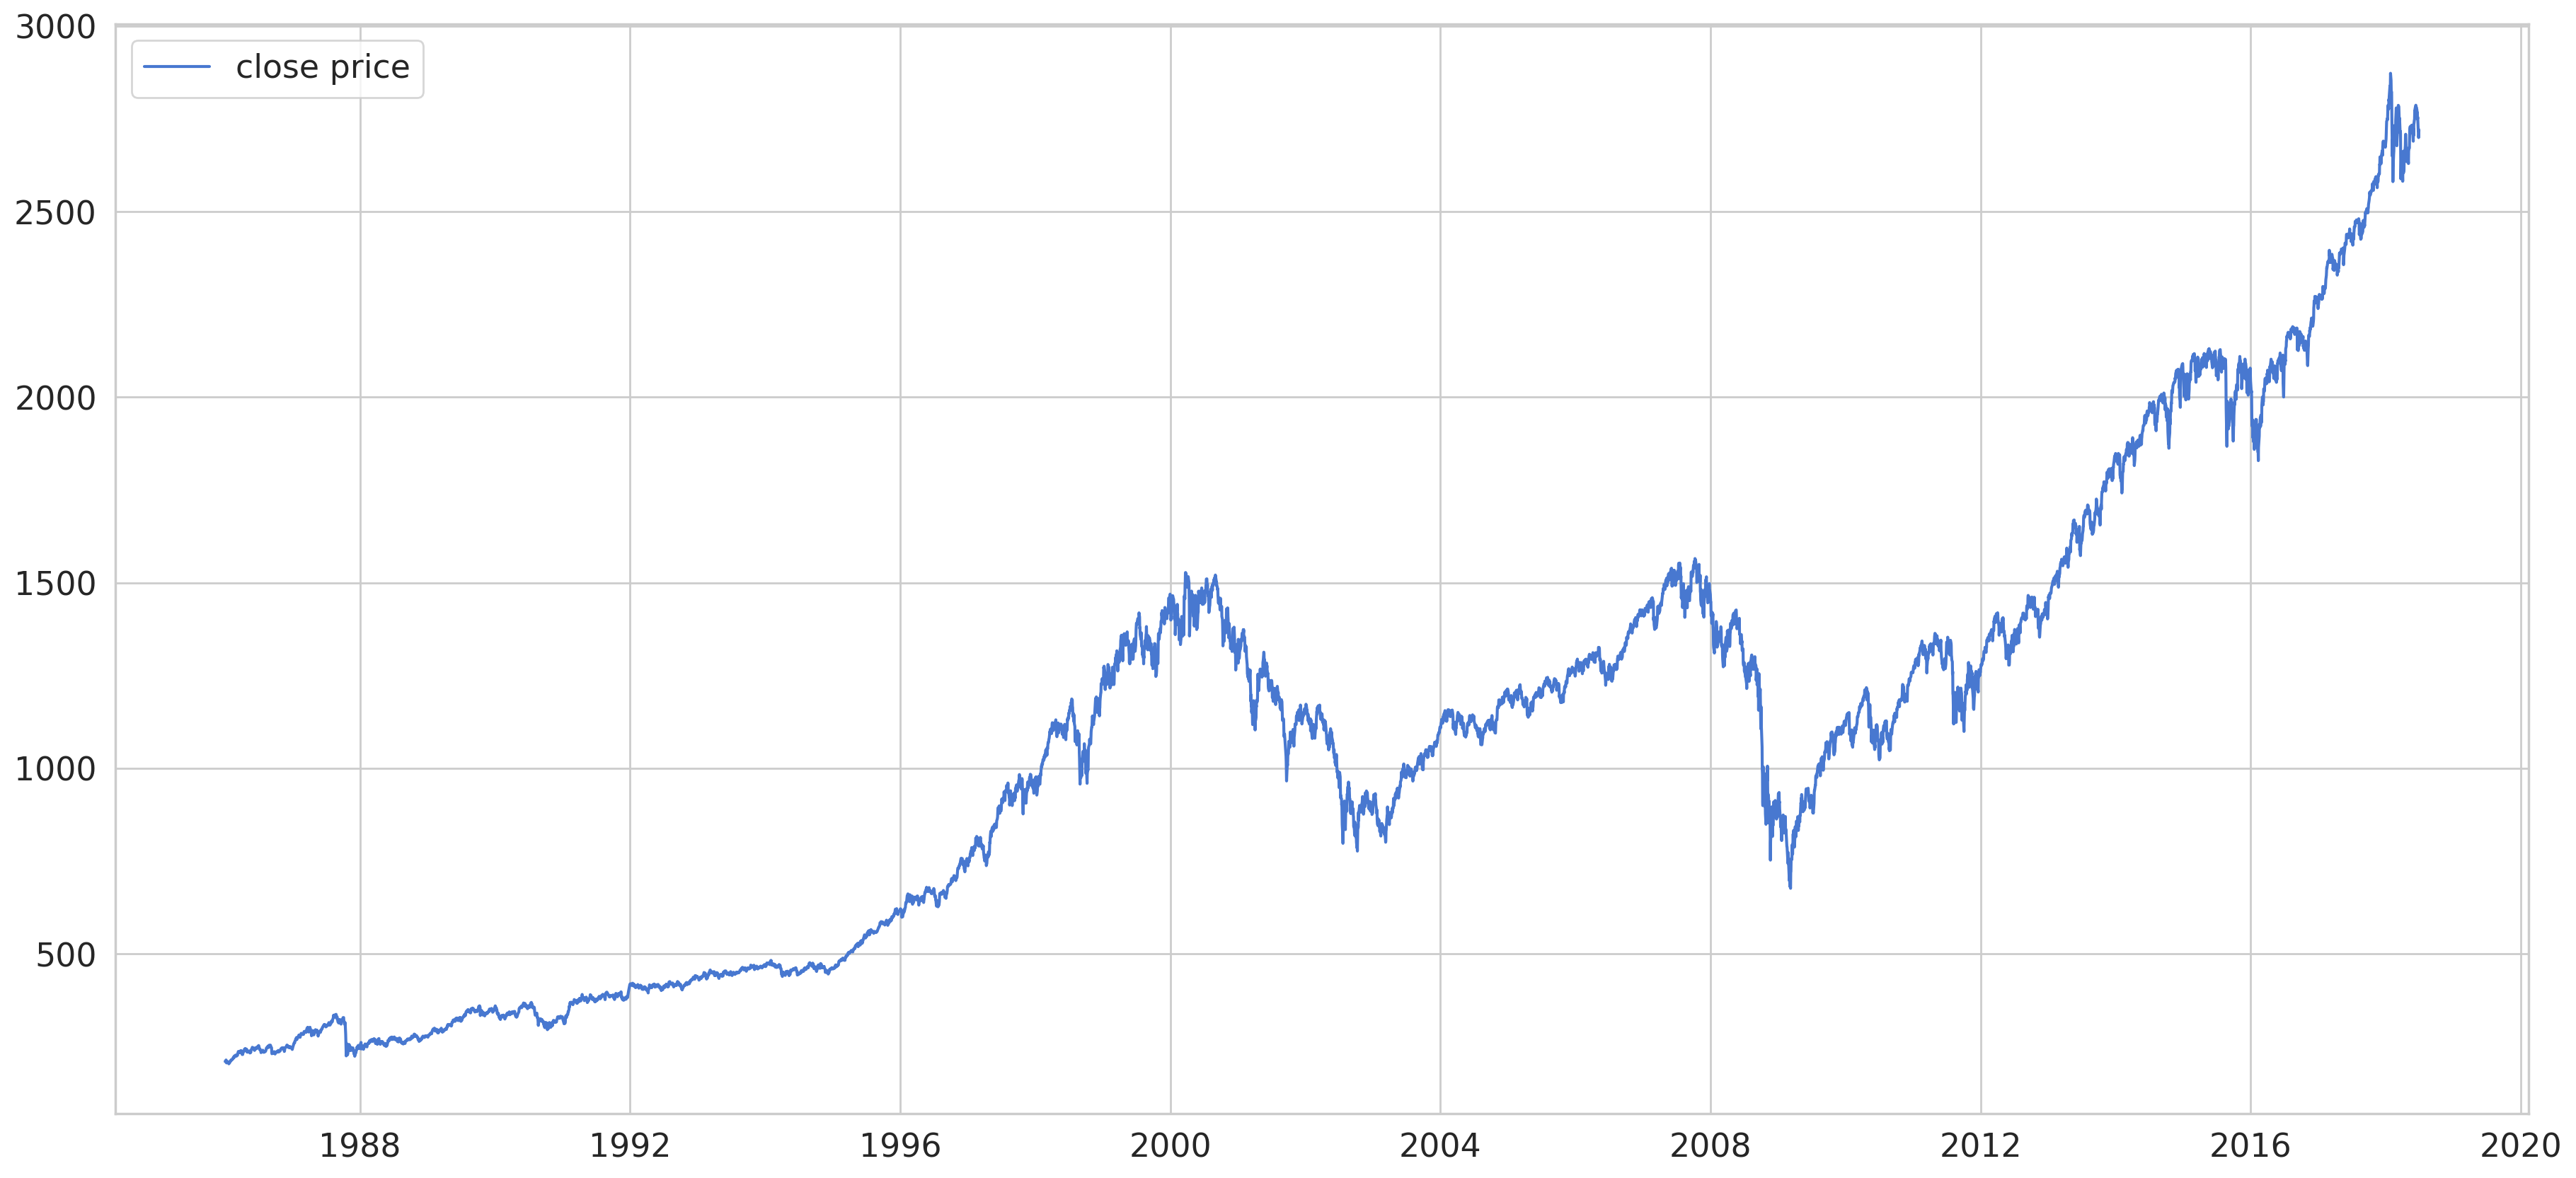

In [ ]:
plt.plot(df, label='close price')
plt.legend();

In [ ]:
train_size = int(len(df) * 0.87)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7127, 1) (1065, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

<ipython-input-28-419ee0323bae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-28-419ee0323bae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [ ]:
print(train.shape, test.shape)

(7127, 1) (1065, 1)


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7097, 30, 1)


In [ ]:
X_train.shape[1]

30

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
200/200 [==============================] - 6s 11ms/step - loss: 0.1945 - val_loss: 0.3216
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1441 - val_loss: 0.1709
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1159 - val_loss: 0.1746
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1267 - val_loss: 0.1820
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1546 - val_loss: 0.1747
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1494 - val_loss: 0.1878
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1528 - val_loss: 0.1923
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1510 - val_loss: 0.1953
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1475 - val_loss: 0.2182
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1515 - val_loss: 0.2

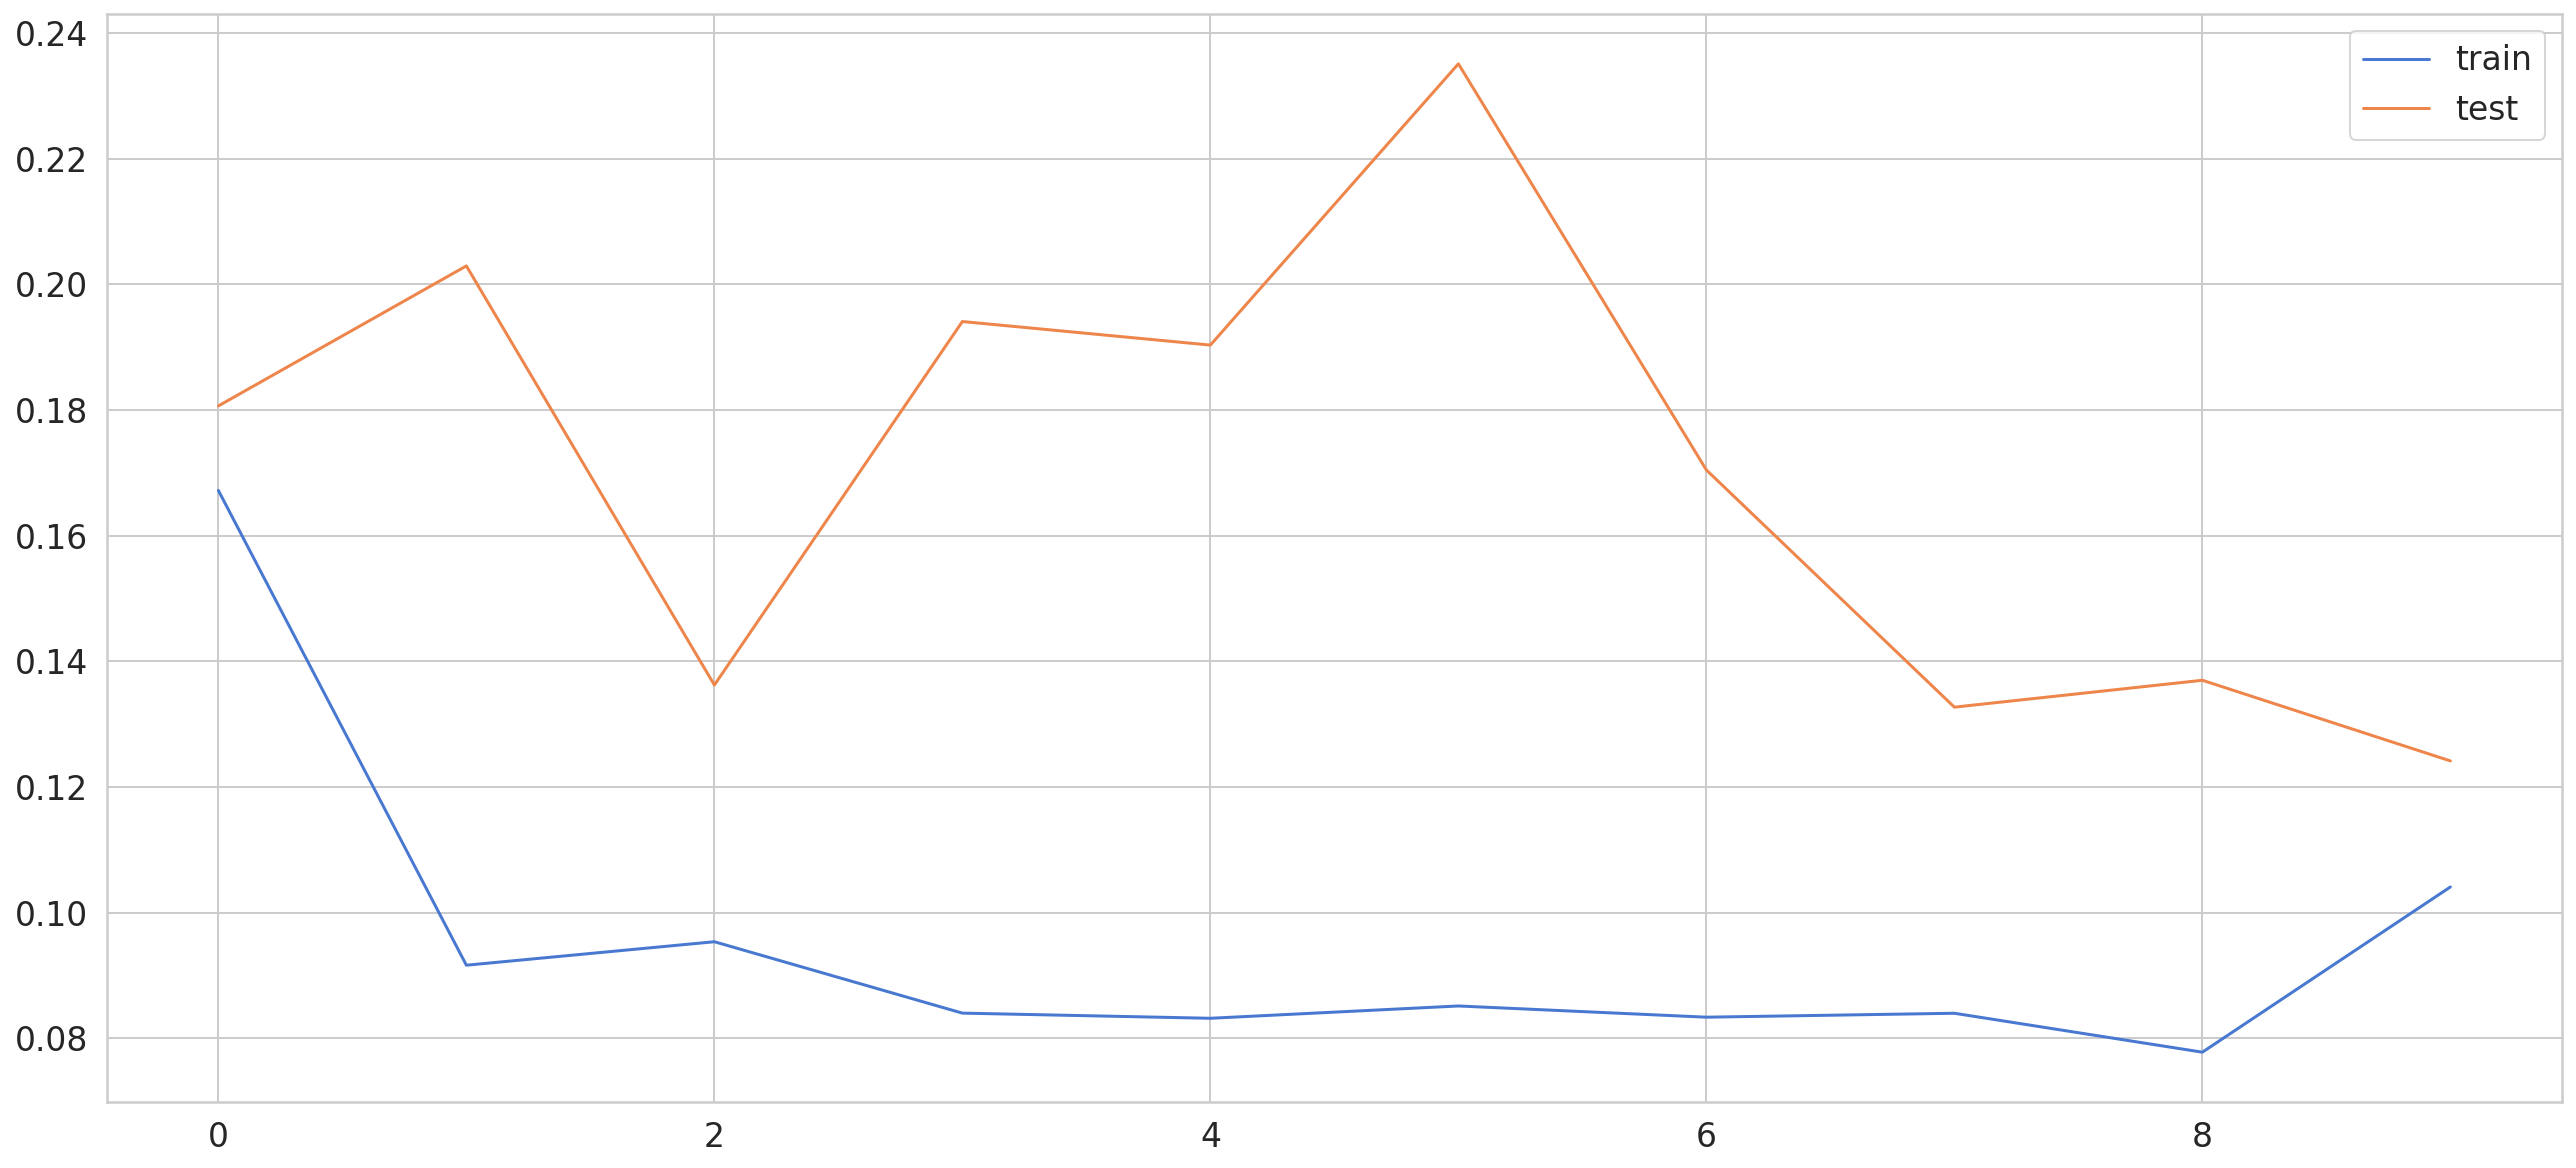

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

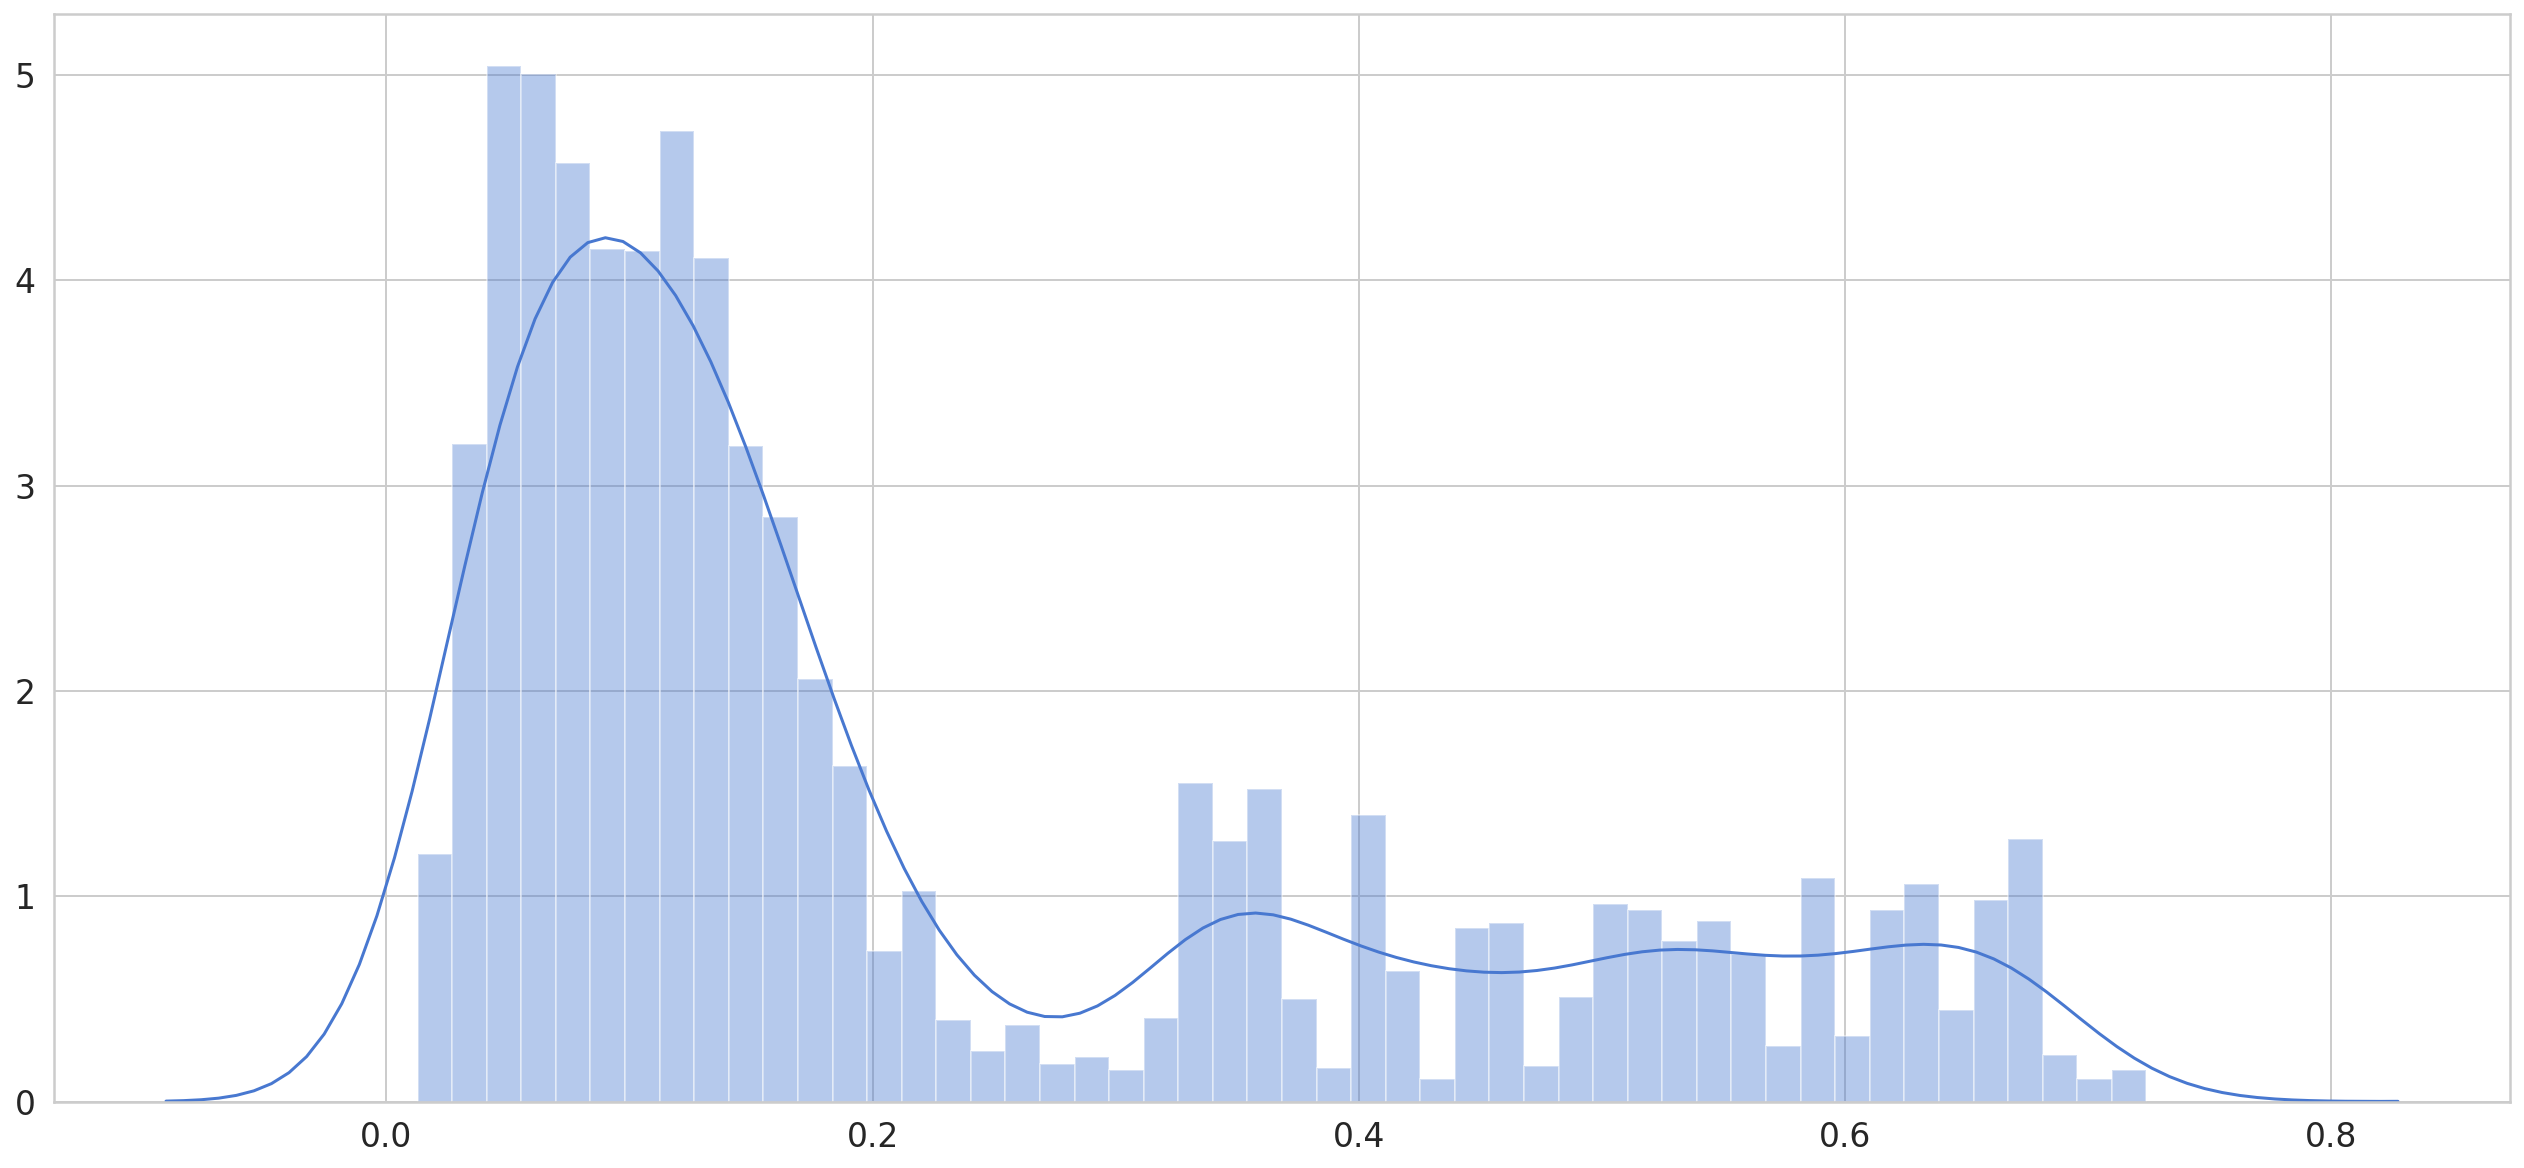

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

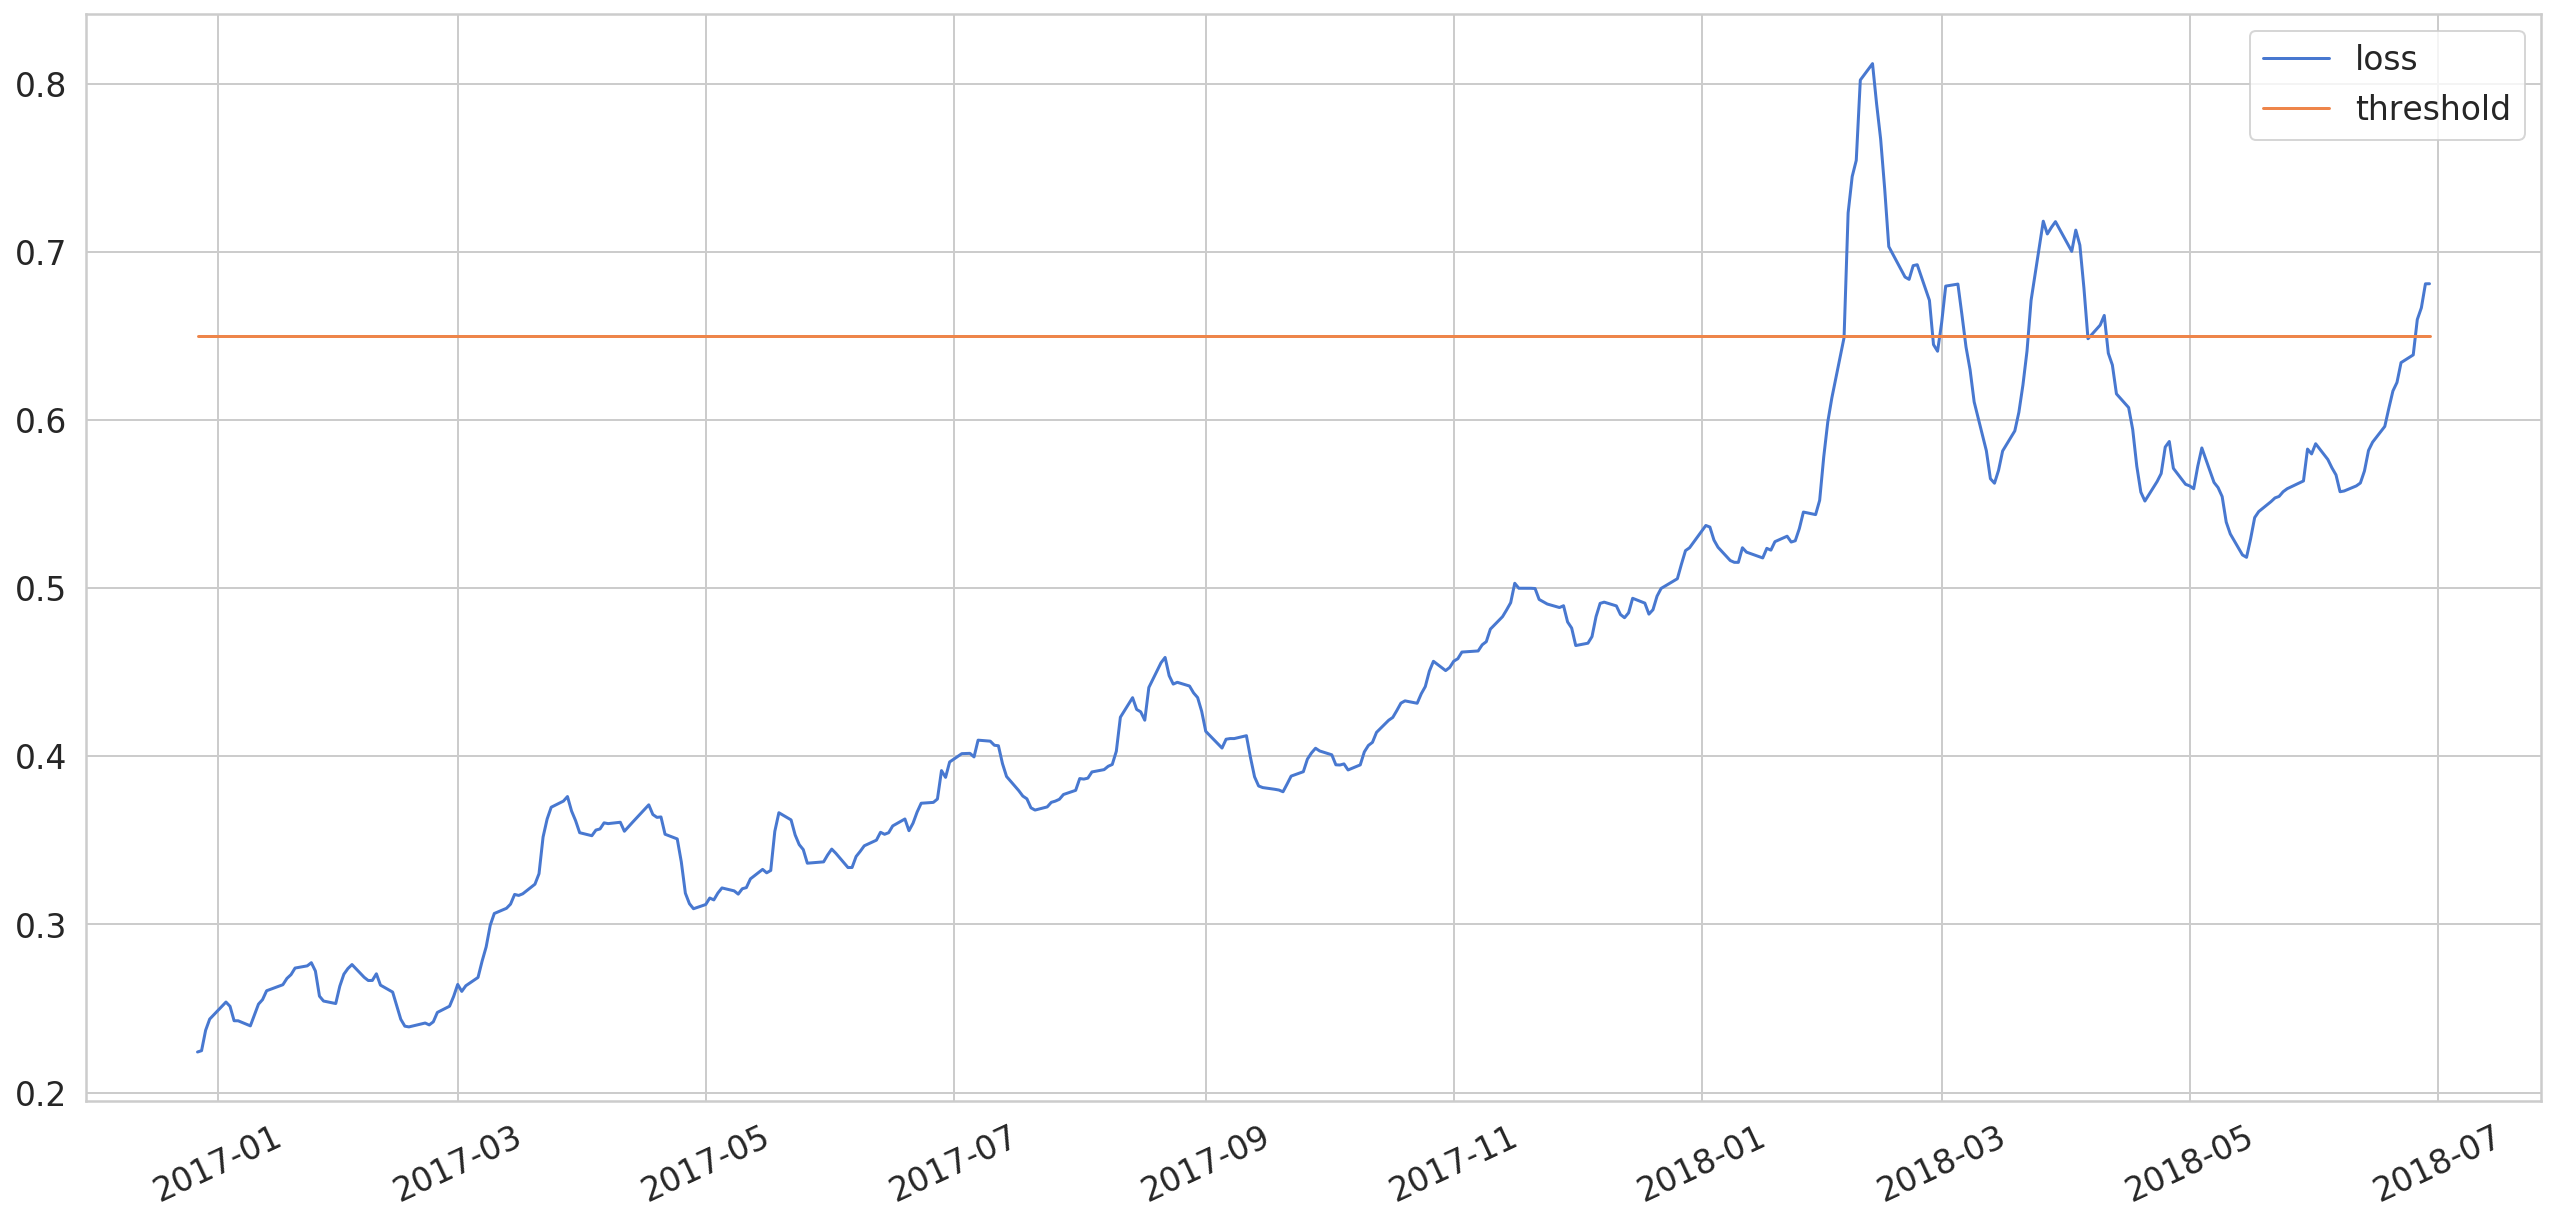

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.723123,0.65,True,3.193456
2018-02-07,0.744779,0.65,True,3.168136
2018-02-08,0.754374,0.65,True,2.979068
2018-02-09,0.802155,0.65,True,3.051476
2018-02-12,0.811910,0.65,True,3.119939


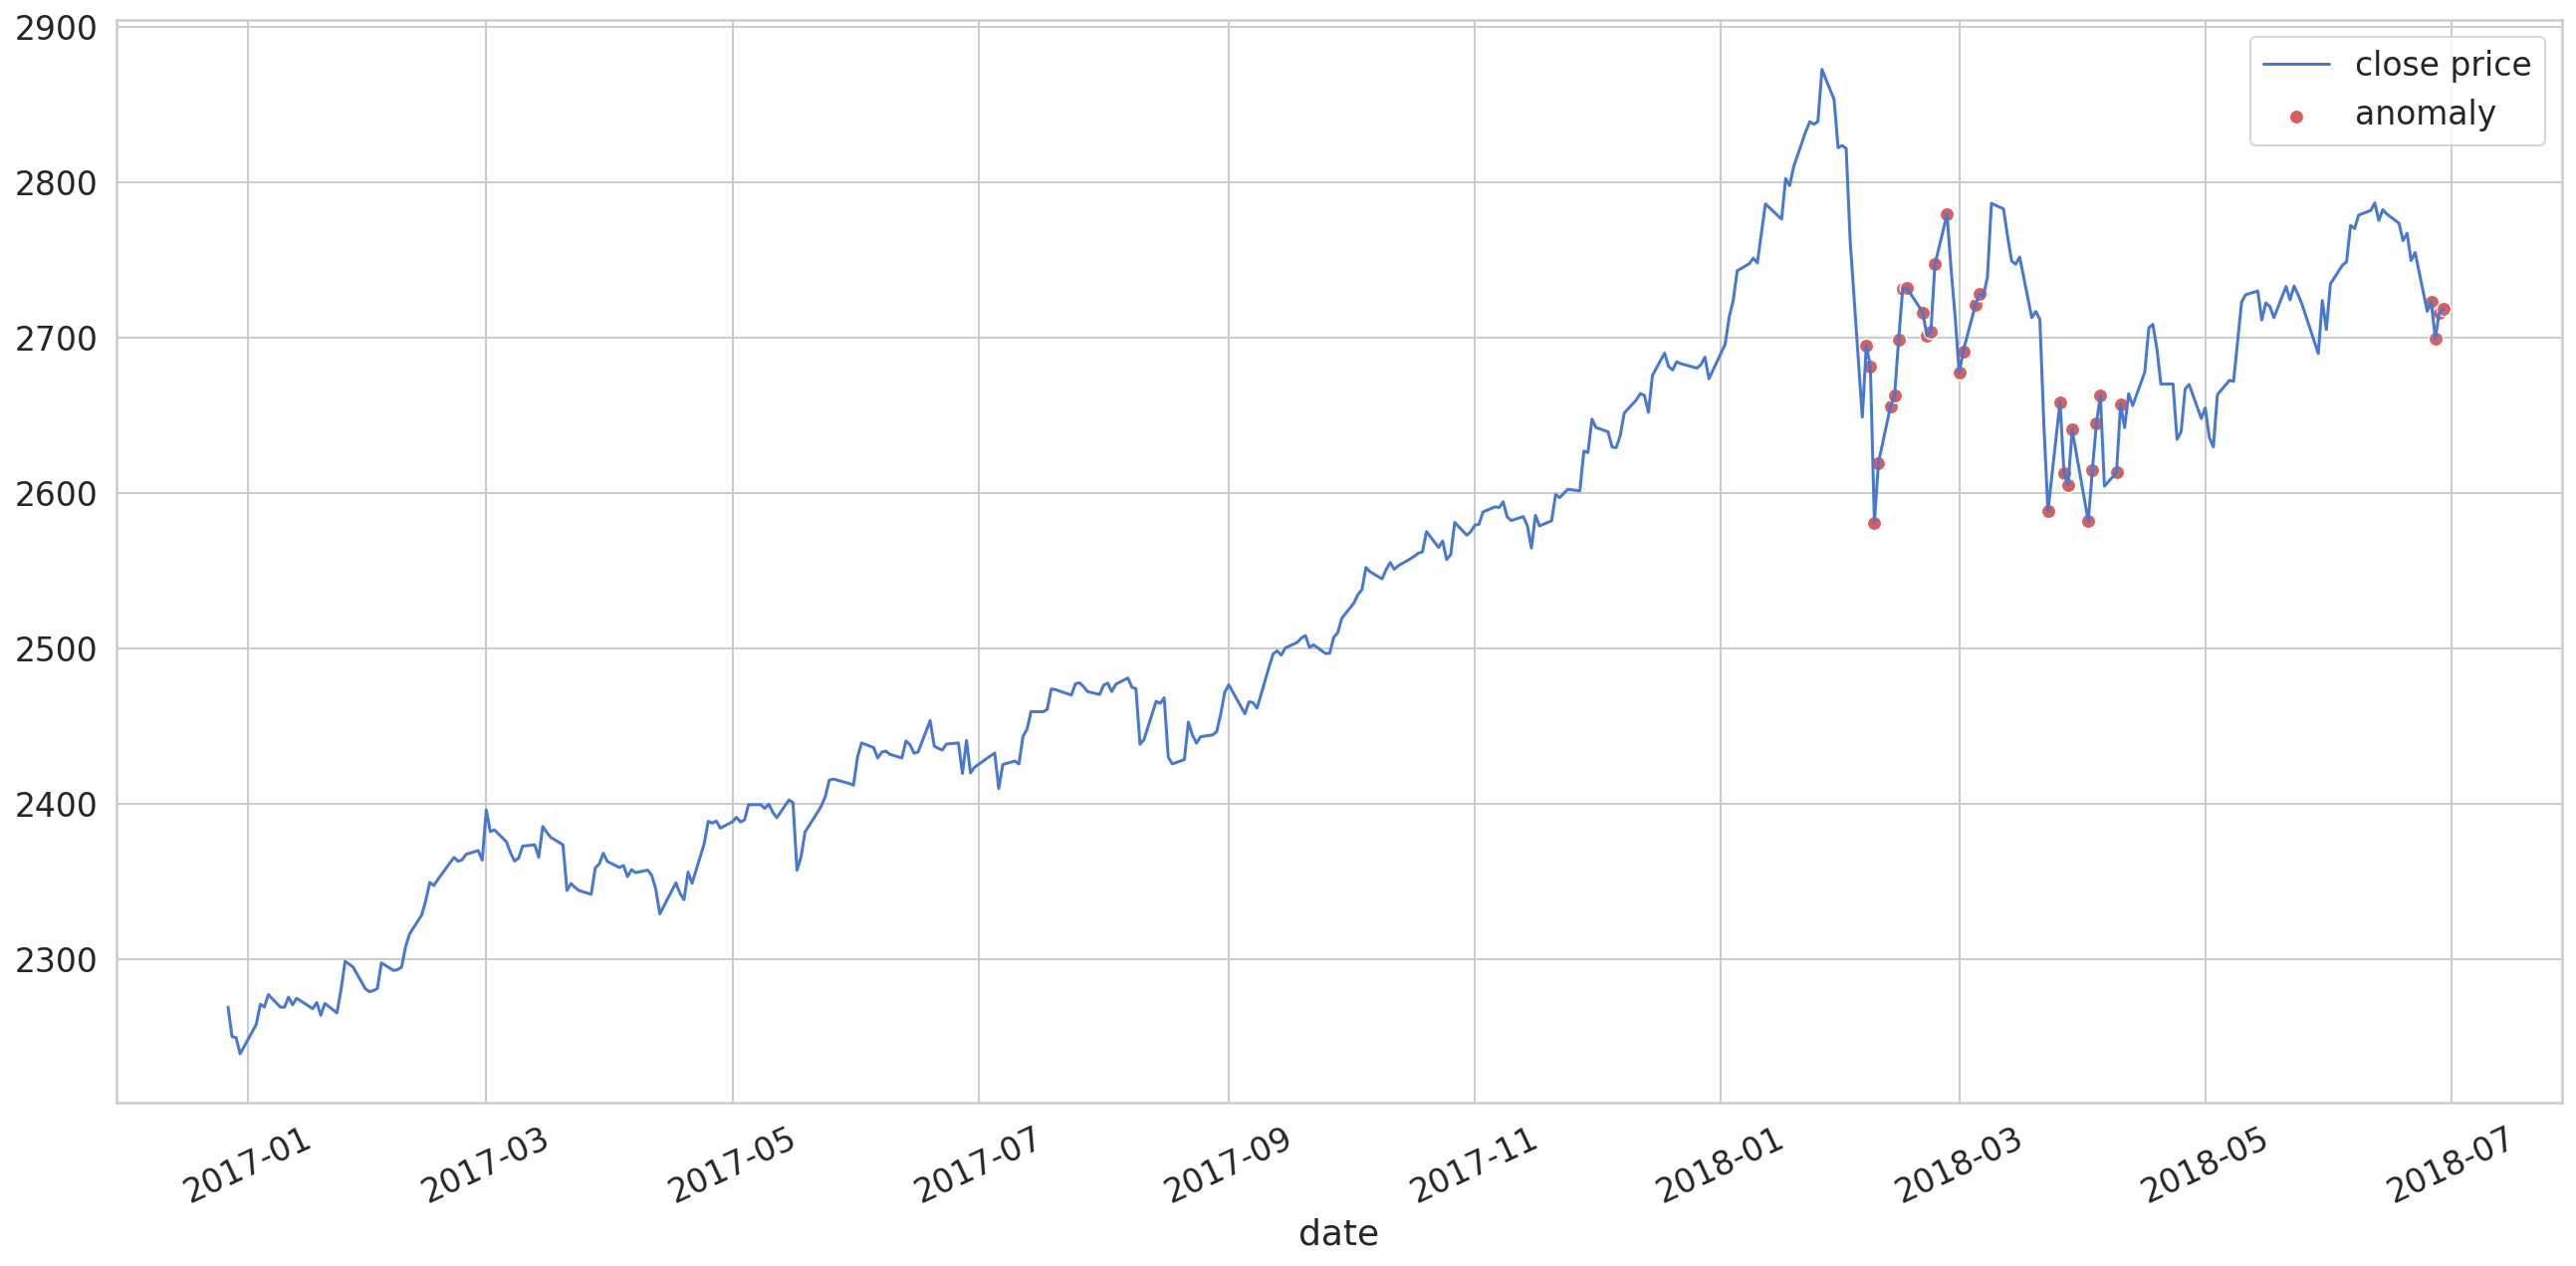

In [ ]:
plt.plot(
  test[TIME_STEPS:].index,
  scaler.inverse_transform(test[TIME_STEPS:].close),
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();